### This is a Simulated Process dataset with faults - used as a trial version related to a paper machine paper break dataset, although fewer features and far fewer samples.

### This version uses the simulated sensor positions as well as the single and double derivatives imitating a 'velocity' and 'acceleration' of sensor position.  The EDA and descriptions are included here as well as in the base case only using the simulated sendor values. 

#### The business case is simple: Identifying a likely fault before it occurs is intended to give time to adjust the process to avoid the condition which will improve production, efficiency, and reduce cost of downtime.

The dataset has two classes, normal or running (0) and fault or stopped (1).

These Classes are ammended to reflec the likelihood of an impending fault and are set to 6 at a fault.  Prior samples are set to class 1 through 4 to represent 20% to 80% likelihood of an upcoming failure and the sample prior to the modelled fault is set to 5 (100%) as the next sample is a fault.

The assumption is that the process conditions change enough prior to the fault to detect the condition, even if they appear to be within a normal range or deviation is consistent in one direction ths leading to the fault.  This is the case with this simulated dataset.  In addition there are deviations modelled between faults that do not progress to the point of failure.  Of nterest is if these will be classified as a warning even though there is no fault associated with them and thus the class relabelling will miss these deviations.

The sample process values continue at a normal state after a fault.  There isn't a simulated time for restart or restoring the process.  The samples only simulate running state leading to a fault condition.



### Workflow:  
Import dataset and set a probability class of future or impending fault to the samples prior to the failure.  

Scale the dataset and build a numpy array of 'images' to have 6 time samples per image.  The first image will be samples 0 to 5.  The second will be sample 1 to 6 and so on.  The image sequence resets at a fault, when the last sample in the image is a fault.  Therefore the number of images is the number of samples less 5 for each fault sample.  In this simulated dataset, the last sample is a fault.

The image samples will be split into a train and test set.  In this simulation, the train and test sets are reversed from th case using only sensor position values.  There are only 12 fault conditions so the training set (5 faults) will not be broken into a train and validation set. This will be considered in the real world paper machine sheet break dataset. 

In [1]:
#Import General Libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import livelossplot
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
df=pd.read_csv('Simulated_Process_with_Faults.csv')

In [3]:
df[35:40]  # Shows the first fault at sample 36

,A,B,C,D,E,F,G,H,I,J,Y
35,26.264961,14.680666,70.037826,9.703911,19.001080,46.053903,38.993309,80.632190,54.953338,30.413141,0
36,25.332553,14.268102,69.720476,10.461064,18.853275,47.187518,38.608956,80.803896,54.804901,30.675685,1
37,25.104936,15.223484,70.607932,9.582930,18.959019,46.046481,40.400661,80.289801,55.138524,29.707611,0
38,24.714939,14.719674,69.822098,10.389657,18.970657,45.787828,40.146595,80.191548,54.797006,30.256215,0
39,25.455412,15.503246,69.088325,10.215335,18.967639,46.316489,40.378815,79.653693,54.749951,30.025789,0


In [4]:
df.describe()

,A,B,C,D,E,F,G,H,I,J,Y
count,433.000000,433.000000,433.000000,433.000000,433.000000,433.000000,433.000000,433.000000,433.000000,433.000000,433.000000
mean,25.168344,14.896769,70.005204,10.168779,18.984416,46.121607,39.810838,80.121492,54.995565,30.066922,0.027714
std,0.601884,0.468787,0.580685,0.612188,0.039036,0.362585,0.429131,0.367388,0.294105,0.231173,0.164341
min,24.000894,13.552212,69.004415,9.000356,18.835092,45.509100,38.009353,79.501034,54.504090,29.700683,0.000000
25%,24.663986,14.529991,69.503230,9.660401,18.959756,45.868479,39.585448,79.841531,54.749951,29.882010,0.000000
50%,25.177905,14.906474,70.040267,10.149039,18.987091,46.088526,39.807807,80.127435,54.989563,30.057825,0.000000
75%,25.660638,15.287999,70.542433,10.674117,19.014154,46.338741,40.155080,80.362560,55.256730,30.233012,0.000000
max,26.703821,15.747205,70.996213,12.011812,19.049531,47.586771,40.490089,81.581114,55.497475,30.867992,1.000000


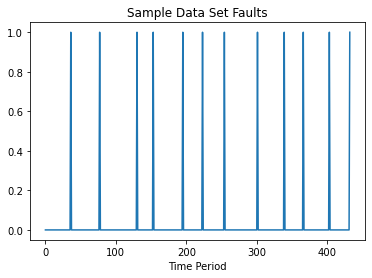

In [5]:
# PLot the fault conditions
plt.plot(df['Y'])
plt.title("Sample Data Set Faults")
plt.xlabel('Time Period')
plt.show()

#### Examine the simulated dataset of process values and the faults under the 'Y' feature.

<Figure size 1152x720 with 0 Axes>

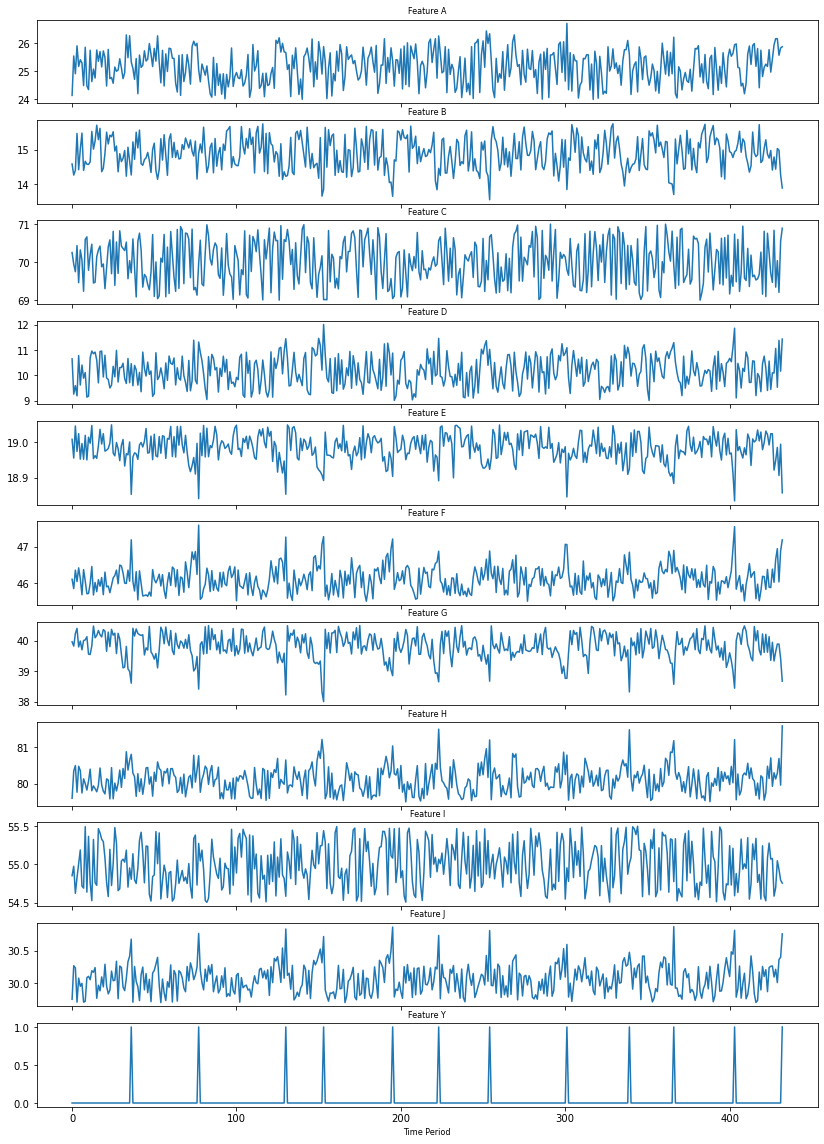

In [6]:
Features = ['A','B','C','D','E','F','G','H','I','J','Y']
fig = plt.figure(figsize = (16,10))
fig,(ax)  = plt.subplots(11, 1, figsize = (14, 20), sharex = True )
for i in range(11):
    ax[i].plot(df[Features[i]])
    ax[i].set_title("Feature " + Features[i], size=8)
plt.xlabel('Time Period', size=8)
plt.show()

Visually we can see the faults in the simulated process measurement.  These are created with a bias, and a random variation plus/minus a secondary bias multiplied by a weight from 0.1 to 1.0.  The weight increases for 0.1 to 0.4 at varyinig rates before jumping to 1.0.  At 1.0 there is a fault.  

The objective is to identify deviation trends from normal indicating an impending fault, thus allowing the fictional operators, or operating system to take action.

Features 'B' and 'I' do not have a secondary bias.  The other do have a bias but not necessarily greater than the range of the normal process noise, but applying in a single direction (plus or minus) versus the random process values variation.
The secondary bias is applied at lower values periodically between the faults as well, simulating a deviating process that returns without experiencing a fault.  These points are not identified under the 'Y' feature, but may be predicted by the model.

#### Build two derivative df's 'velocity' and 'acceleration'.  Assume unit time interval between samples.

In [7]:
df_v = pd.DataFrame(columns=df.columns)
df_v['Y'] = df['Y']
df_v.iloc[0,0:-1] = 0
df_v.iloc[1:,0:-1] = (np.array( df.iloc[1:,0:-1]) - np.array( df.iloc[0:-1,0:-1]) )/1

In [8]:
df_v.head()

,A,B,C,D,E,F,G,H,I,J,Y
0,0,0,0,0,0,0,0,0,0,0,0
1,1.402895,-0.320583,-0.303077,-1.396182,-0.052796,-0.253978,-0.139375,0.744784,0.122938,0.515904,0
2,-0.63135,0.137101,-0.199484,0.335364,0.090388,0.503401,0.411612,0.15108,-0.353518,-0.03336,0
3,0.992238,1.065215,0.684377,-0.403288,-0.071673,-0.311258,0.164555,-0.729855,0.208112,-0.525274,0
4,-0.732767,-1.047461,-0.971462,1.596296,0.050024,0.372937,-0.605095,0.710426,0.182396,0.368147,0


In [9]:
df_a = pd.DataFrame(columns=df.columns)
df_a['Y'] = df['Y']
df_a.iloc[0,0:-1] = 0
df_a.iloc[1:,0:-1] = (np.array( df_v.iloc[1:,0:-1]) - np.array( df_v.iloc[0:-1,0:-1]) )/1

In [10]:
df_a.head()

,A,B,C,D,E,F,G,H,I,J,Y
0,0,0,0,0,0,0,0,0,0,0,0
1,1.402895,-0.320583,-0.303077,-1.396182,-0.052796,-0.253978,-0.139375,0.744784,0.122938,0.515904,0
2,-2.034246,0.457684,0.103594,1.731546,0.143184,0.757379,0.550987,-0.593704,-0.476456,-0.549264,0
3,1.623589,0.928113,0.883861,-0.738652,-0.162061,-0.814658,-0.247056,-0.880935,0.561629,-0.491915,0
4,-1.725005,-2.112676,-1.655839,1.999585,0.121697,0.684194,-0.76965,1.440281,-0.025715,0.893421,0


In [11]:
df_p = df.drop('Y', axis = 1)
df_v = df_v.drop('Y', axis = 1)
df_a = df_a.drop('Y', axis = 1)

In [12]:
# Scale the data.  Scaling from 0 to 1 will also allow for image show of grouped samples.
scaler = MinMaxScaler()

df_p=scaler.fit_transform(df_p)
df_v=scaler.fit_transform(df_v)
df_a=scaler.fit_transform(df_a)

In [13]:
df_p.min(), df_p.max(), df_v.min(), df_v.max(), df_a.min(), df_a.max()

(0.0, 1.0000000000000018, 0.0, 1.0000000000000002, 0.0, 1.0)

## Now build the image dataset.
### There are fewer samples in the image set, 373 vs 433. So the Classification labels need to be rebuilt with the images.

In [14]:
image_count = len(df_p)-5*df['Y'].sum()
image_count

373

In [15]:
images = np.zeros((image_count,18,10))
Y = np.zeros((image_count)).astype(int)
lbl = np.zeros((image_count)).astype(int)

In [16]:
# Re-Build Image set with Y labels as 1 to 5 for images 5 time periods and less in advance of actual tear.
# Each image has six rows, equal to the 5 warning samples and the fault sample
# Build the image in one slice - six rows, ten values per row of subsequent 10 time periods, shifting one period at a time
print(('{:<10}{:<14}{:<14}{:<10}').format('image#', 'first row', 'last row', 'Y'))
i = 0
for c in range(image_count):
    images[c,0:6,:] = df_p[i:i+6,:] 
    images[c,6:12,:] = df_v[i:i+6,:] 
    images[c,12:18,:] = df_a[i:i+6,:] 
    lbl[c] = df['Y'][i+5]
    if df['Y'][i+5] == 1:
        Y[c] = 6
        for j in range(5):
            Y[c-1-j] = 5-j
        print(('{:<10}{:<14}{:<14}{:<10}').format(c, i, i+5, df['Y'][i+5])) 
        i = i + 6
    else:        
        Y[c] = df['Y'][i+5]        
        i = i + 1

image#    first row     last row      Y         
31        31            36            1         
67        72            77            1         
115       125           130           1         
133       148           153           1         
170       190           195           1         
193       218           223           1         
219       249           254           1         
261       296           301           1         
294       334           339           1         
316       361           366           1         
348       398           403           1         
372       427           432           1         


In [17]:
images.shape

(373, 18, 10)

In [18]:
# Check the length and sum of the class labels that they match the number of images and the class sums from the RF model
len(Y), type(Y), sum(Y), sum(lbl)

(373, numpy.ndarray, 252, 12)

### View the image slices below, each one containing information for the six time periods.  A section of the simulated X Test set is displayed.

### Each image has position related values in rows 0-5, 'velocity' values in rows 6-11, and 'acceleration' values in  rows 12-17.   Each row has 10 pixels relating to normalized values for the 10 simulated sensors.

x_test image and label


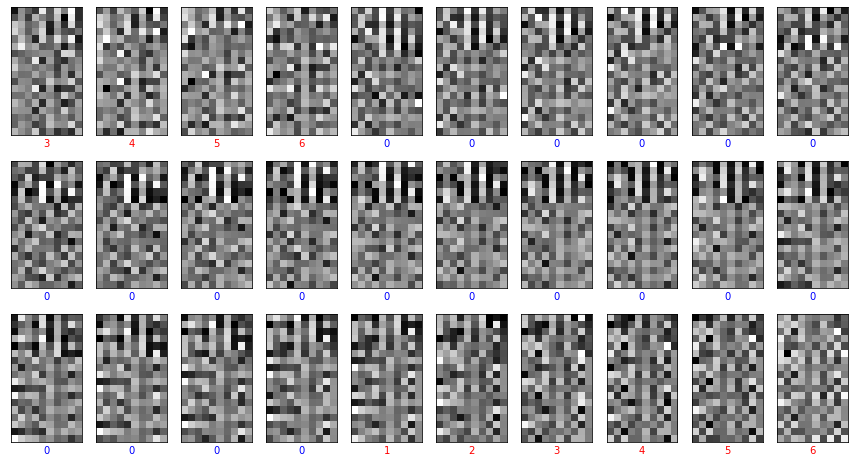

In [19]:
# Compare results in a display of images
colr = ['blue', 'red']
print('x_test image and label')
plt.figure(figsize=(15,8))
for i in range(190,220):
    plt.subplot(3,10,i-189)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap='gray')
    plt.xlabel(Y[i], c=colr[1*(Y[i]>0)]) 
plt.show()

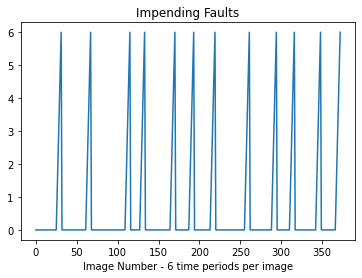

In [20]:
# Plot the fault conditions versus the image number (there are fewer images than samples as noted above)
plt.plot(Y)
plt.title('Impending Faults')
plt.xlabel('Image Number - 6 time periods per image')
plt.show()

In [21]:
# Save a viewable copy of x_test to disply results
x_te = images[:220]

In [22]:
# Subtract 0.5 from the image values for a range of -0.5 to +0.5 and Reshape the image array for CNN input

images = images.reshape(373, 18, 10, 1)

In [23]:
# Split into Train and Test set
xCNN_train, xCNN_test = images[220:], images[0:220]

yCNN_train, yCNN_test = Y[220:], Y[0:220]

In [24]:
xCNN_train.shape, xCNN_test.shape, yCNN_train.shape, yCNN_test.shape

((153, 18, 10, 1), (220, 18, 10, 1), (153,), (220,))

In [25]:
yCNN_train[20:45]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6,
       0, 0, 0])

In [26]:
# Original class labels corresponding to the last time sample in each image - Constructed with the images array
lbl[20+220:45+220]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0])

#### The first 10 time samples fills the first image, so the 36th sample is the last row on image 27.

### Build a CNN Classification model with 6 output classes 0 to 5.

In [27]:
from keras import Sequential, regularizers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


Using TensorFlow backend.


In [28]:
# Build Model

model = Sequential()
model.add(Conv2D(4, (3,3), input_shape = (18, 10, 1),  activation = 'relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dense(units = 7, activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [29]:
live_plot = livelossplot.PlotLossesKeras()

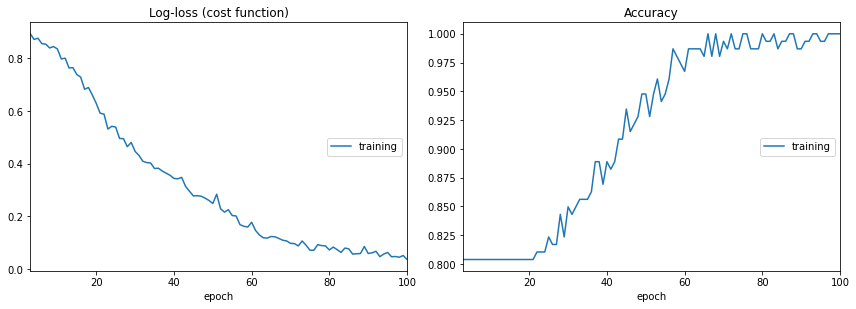

Log-loss (cost function):
training   (min:    0.036, max:    1.284, cur:    0.036)

Accuracy:
training   (min:    0.673, max:    1.000, cur:    1.000)


In [30]:
# Fit the model & train for 100 epochs initially, livelossplot in callbacks, 
#  Skip a validation split since there are only 7 faults in the training set.
model.fit(xCNN_train, yCNN_train, validation_split = 0.0,
          callbacks = [live_plot], initial_epoch = 0, epochs = 100, batch_size = 10)

In [31]:
# Put results value in y_pred
y_pred = model.predict(xCNN_test).argmax(axis=1)
y_prob = model.predict_proba(xCNN_test)

In [32]:
y_pred[20:40]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [33]:
yCNN_test[20:40]

array([0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0])

### Plot the training results

In [34]:
y_pred_train = model.predict(xCNN_train).argmax(axis=1)

In [35]:
y_pred_train[60:80]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 0, 0, 0, 0, 0],
      dtype=int64)

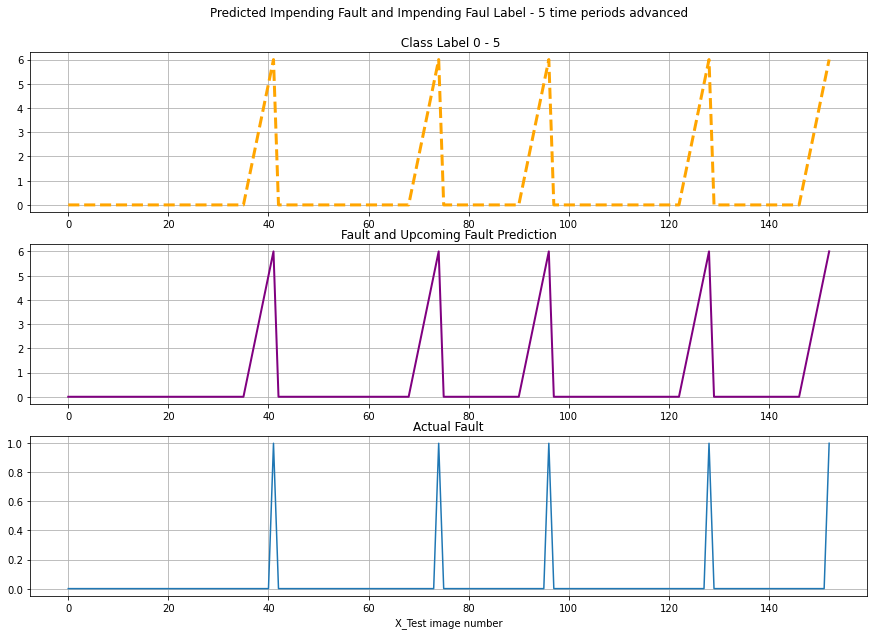

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,10))
ax1.plot(yCNN_train, label = "Class Label 0 to 5", ls = '--', lw = 3, c ='orange')
ax2.plot(y_pred_train, label ="Class Prediction", c ='purple', lw = 2)
ax1.set_title('Predicted Impending Fault and Impending Faul Label - 5 time periods advanced\n\n Class Label 0 - 5')
ax2.set_title('Fault and Upcoming Fault Prediction')
ax3.plot(lbl[220:])
ax3.set_title("Actual Fault")
ax1.grid()
ax2.grid()
ax3.grid()
ax3.set_xlabel('X_Test image number')
plt.show()

In [37]:
# Compare results in table of predictions from index 30 to 44
class_labels = ['normal','20%','40%','60%','80%','100%', 'FAULT']
correct = ['No', 'Yes','Yes','Partly']
dash='='*85
print(dash,'\n','{:<10}{:<14}{:<14}{:12}{:14}{:14}'.format('x_test','prediction','actual','Correct',
                                                           'Likelihood','% Prob of Class'))
print(dash)
j = 104 #offset from 0 to wanted begining index for sample
for i in range(35):
    val_p = int(y_pred[i+j])
    val_a = int(yCNN_test[i+j])
    y_p = class_labels[val_p]
    y_a = class_labels[val_a]
    correctness = 0 + 1*(val_p==0 and val_a== 0) + 2*(val_a>0)*(val_p==val_a) + 3*(val_a>0)*(val_p>0)*(val_p!=val_a)
    print((' {:<10}{:<14}{:<16}{:<14}{:<14}{:6}').format(i+j, y_p, y_a, correct[correctness],
                                                        min(100,int(y_pred[i+j]*20)), int(100*y_prob[i+j][y_pred[i+j]])))

 x_test    prediction    actual        Correct     Likelihood    % Prob of Class
 104       normal        normal          Yes           0                 99
 105       normal        normal          Yes           0                 99
 106       normal        normal          Yes           0                 99
 107       normal        normal          Yes           0                 99
 108       normal        normal          Yes           0                 99
 109       normal        normal          Yes           0                 99
 110       20%           20%             Yes           20                76
 111       100%          40%             Partly        100               80
 112       100%          60%             Partly        100               56
 113       80%           80%             Yes           80                80
 114       60%           100%            Partly        60                36
 115       FAULT         FAULT           Yes           100               94
 116   

### The prediction above gives an early indication of a fault.

x_test image and prediction: Yes / No - Prediction matches Class, Partly - Prediction and Actual are > 0


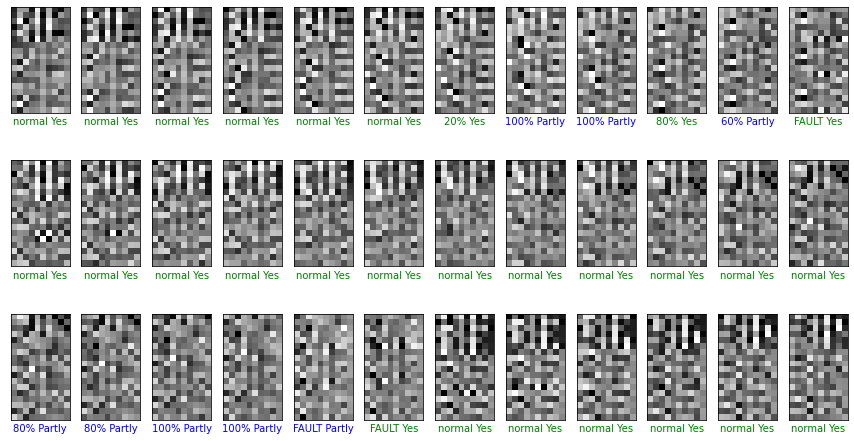

In [38]:
# Compare results in a display of 15 images from index 16 to 30
j=0 #(offset to view subset)
col_r = ['r', 'g', 'g', 'blue']
print('x_test image and prediction: Yes / No - Prediction matches Class, Partly - Prediction and Actual are > 0')
plt.figure(figsize=(15,8))
for i in range(104,140):
    plt.subplot(3,12,i-103)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_te[i+j], cmap='gray')
    val_p = int(y_pred[i+j])
    val_a = int(yCNN_test[i+j])
    correctness = 0 + 1*(val_p==0 and val_a== 0) + 2*(val_a>0)*(val_p==val_a) + 3*(val_a>0)*(val_p>0)*(val_p!=val_a)
    lab_l = (class_labels[val_a])
    plt.xlabel(class_labels[y_pred[i+j]]+' '+str(correct[correctness]), c = col_r[correctness])
plt.show()

#### The CNN model warned of the faults 3 or more time periods in advance in 5 of 7 faults in the test set, but missed one fault.

#### Retraining the model will give similar, but sightly different results.

#### Conceptually this approach works and may be able to provide early warning of fault not indicated by current operating sensor values.

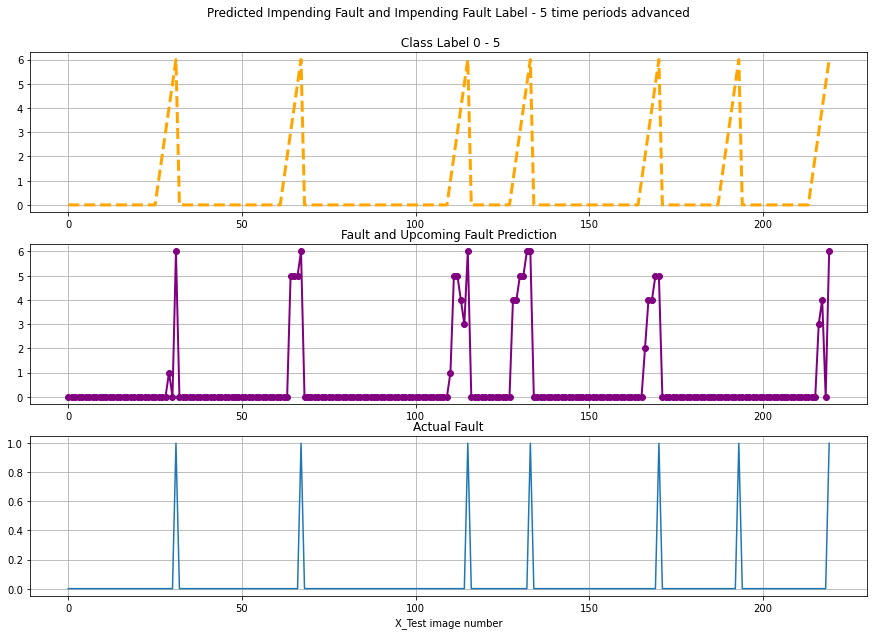

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,10))
ax1.plot(yCNN_test, label = "Class Label 0 to 5", ls = '--', lw = 3, c ='orange')
ax2.plot(y_pred, label ="Class Prediction", c ='purple', lw = 2, marker='o')
ax1.set_title('Predicted Impending Fault and Impending Fault Label - 5 time periods advanced\n\n Class Label 0 - 5')
ax2.set_title('Fault and Upcoming Fault Prediction')
ax3.plot(lbl[0:220])
ax3.set_title("Actual Fault")
ax1.grid()
ax2.grid()
ax3.grid()
ax3.set_xlabel('X_Test image number')
plt.show()

#### The confusion matrix and classification report below are not excellent in the mid range warning classes.  Matching the warning classes exactly is not required, just that warnings occur several time periods prior to the fault.

In [40]:
print('CNN Model X Test Confusion Matrix\n', confusion_matrix(yCNN_test, y_pred))

CNN Model X Test Confusion Matrix
 [[178   0   0   0   0   0   0]
 [  5   1   0   0   1   0   0]
 [  4   0   1   0   1   1   0]
 [  2   0   0   1   1   3   0]
 [  1   1   0   0   3   2   0]
 [  3   0   0   1   0   2   1]
 [  1   0   0   0   0   1   5]]


In [41]:
print('CNN Classification Report\n', classification_report(yCNN_test, y_pred))

CNN Classification Report
               precision    recall  f1-score   support

           0       0.92      1.00      0.96       178
           1       0.50      0.14      0.22         7
           2       1.00      0.14      0.25         7
           3       0.50      0.14      0.22         7
           4       0.50      0.43      0.46         7
           5       0.22      0.29      0.25         7
           6       0.83      0.71      0.77         7

    accuracy                           0.87       220
   macro avg       0.64      0.41      0.45       220
weighted avg       0.86      0.87      0.84       220



In [42]:
model.save("Simulated_process_w_vel_acc.h5")